Based on Implementation from:
https://www.tensorflow.org/tutorials/generative/cyclegan

Using Generator based on the cycleganPaper.

In [1]:
# add parent dir to syspath
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

# Imports 

In [2]:
# own imports
from models.cyclegan_modified.cyclegan import cyclegan
from models import image_preprocessing
from imageGenerators import load_digits, load_realdata
from imageGenerators.imgGen_simple import synth_generator

import models.common_functions 
# librarys
import tensorflow as tf
import cv2
from pathlib import Path
from matplotlib import pyplot as plt
from os import listdir, mkdir
import os
import numpy as np
import time
import pickle

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
# assert model is running on gpu
from tensorflow.python.client import device_lib
devlist = str(device_lib.list_local_devices())
assert "GPU:0" in devlist

# Parameters 

In [4]:
N_IMAGES = 500
EPOCHS = 4
N_TEST = 5
N_DIGITS = 5
BATCH_SIZE = 1
BUFFER_SIZE = 1000

# all images will be resized to these dimensions
#                  width, height
IMAGE_DIMENSIONS = (512, 128)
# whether to train on images with channel==1, or 3
GRAYSCALE = False
N_CHANNELS = 1 if GRAYSCALE else 3

#              height,              width,               channels
IMAGE_SHAPE = (IMAGE_DIMENSIONS[1], IMAGE_DIMENSIONS[0], N_CHANNELS)

CHECKPOINTPATH = Path("D:/m2/savedmodels/checkpoints_cyclegan_modified2")

# generate synthetic images (Domain A)

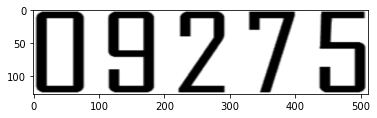

In [5]:
# path to the char74k datset
datasetPath = Path("C:/Users/andre/Desktop/m/datasets/Chars74K/English/Fnt")
# make list mapping integers to list of images of that digit: 
digitImages = load_digits.load_char74k(datasetPath)
# init imagegenerator
synthGenerator = synth_generator(digitImages)
# prepare inputdigits 
digitsTrain = np.random.randint(0,10,size=(N_IMAGES, N_DIGITS))
digitsTest = np.random.randint(0,10,size=(N_TEST, N_DIGITS))
# params to imagegenerator
margins = [20 for _ in range(0, N_DIGITS - 1)] # distances between digits
border = (2, 2, 2, 2) # padding of resultimage
height = IMAGE_DIMENSIONS[1]; width= IMAGE_DIMENSIONS[0] # dimensions to resize result to
# generate images
synthTrain = synthGenerator.generate_images(digitsTrain, margins, border, width, height)
synthTest = synthGenerator.generate_images(digitsTest, margins, border, width, height)

plt.imshow(synthTrain[0], cmap='gray')
plt.show()

# load real images (Domain B)

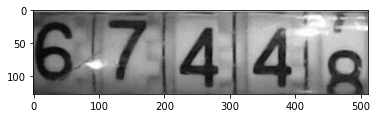

In [6]:
# path to watermeterdataset
wmr_path = Path("C:/Users/andre/Desktop/m/datasets/SCUT-WMN DataSet/easy_samples")
# load random images from dataset, along with the paths used.
# Also resizes images to targetdimensions
real, paths_used = load_realdata.load_wmr(wmr_path, n_images=(N_IMAGES + N_TEST), resize_to=IMAGE_DIMENSIONS)
realTrain = real[0:N_IMAGES]
realTest = real[N_IMAGES:-1]

plt.imshow(realTrain[0], cmap='gray')
plt.show()

# save used images (to continue training)

In [7]:
dataset = (synthTrain, synthTest, realTrain, realTest)
savepath = Path("D:/m2/savedmodels/datasets/traindataset_cyclegan_modified2.pickle")
with open(savepath, "wb") as picklefile:
    pickle.dump(dataset, picklefile, pickle.HIGHEST_PROTOCOL)

In [8]:
# reload old dataset on resuming of training
#with open(savepath, "rb") as picklefile:
#    synthTrain, synthTest, realTrain, realTest = pickle.load(picklefile)

# Preprocess inputs

In [9]:
# make tf-Datasets
train_A = tf.data.Dataset.from_tensor_slices(synthTrain)
train_B = tf.data.Dataset.from_tensor_slices(realTrain)
test_A = tf.data.Dataset.from_tensor_slices(synthTest)
test_B = tf.data.Dataset.from_tensor_slices(realTest)
# define preprocessing operations
def preprocess(imageTensor):
    # reshape (h,w) -> (h,w,1)
    imageTensor = tf.reshape(imageTensor, (imageTensor.shape[0], imageTensor.shape[1], 1))
    if(not GRAYSCALE):
        # duplicate last dimension
        imageTensor = tf.repeat(imageTensor, 3, axis=-1) # should be the same as cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    # to float
    imageTensor = tf.cast(imageTensor, tf.float32)
    # normalize
    imageTensor = (imageTensor / 127.5) - 1
    return imageTensor
# apply preprocessing, cache and batch (data already shuffled)
train_A = train_A \
        .map(preprocess, num_parallel_calls=AUTOTUNE) \
        .cache() \
        .batch(1)
test_A = test_A \
        .map(preprocess, num_parallel_calls=AUTOTUNE) \
        .cache() \
        .batch(1)
train_B = train_B \
        .map(preprocess, num_parallel_calls=AUTOTUNE) \
        .cache() \
        .batch(1)
test_B = test_B \
        .map(preprocess, num_parallel_calls=AUTOTUNE) \
        .cache() \
        .batch(1)

# load model

In [10]:
cgModel = cyclegan(IMAGE_SHAPE, checkpoint_path=CHECKPOINTPATH)

created new Model
done


step 0 took: 1.684507 seconds
step 1 took: 1.590656 seconds
step 2 took: 1.578196 seconds
step 3 took: 1.590884 seconds
step 4 took: 1.590025 seconds
step 5 took: 1.597492 seconds
step 6 took: 1.599159 seconds
step 7 took: 1.600114 seconds
step 8 took: 1.589381 seconds
step 9 took: 1.609702 seconds
step 10 took: 1.589750 seconds
step 11 took: 1.606846 seconds
step 12 took: 1.600660 seconds
step 13 took: 1.607280 seconds
step 14 took: 1.603055 seconds
step 15 took: 1.601996 seconds
step 16 took: 1.608011 seconds
step 17 took: 1.603762 seconds
step 18 took: 1.605622 seconds
step 19 took: 1.595076 seconds
step 20 took: 1.615833 seconds
step 21 took: 1.598009 seconds
step 22 took: 1.603735 seconds
step 23 took: 1.605283 seconds
step 24 took: 1.604119 seconds
step 25 took: 1.608811 seconds
step 26 took: 1.603193 seconds
step 27 took: 1.594433 seconds
step 28 took: 1.612840 seconds
step 29 took: 1.604262 seconds
step 30 took: 1.609170 seconds
step 31 took: 1.608916 seconds
step 32 took: 1.59

step 260 took: 1.609952 seconds
step 261 took: 1.611141 seconds
step 262 took: 1.613401 seconds
step 263 took: 1.610271 seconds
step 264 took: 1.609360 seconds
step 265 took: 1.605804 seconds
step 266 took: 1.608657 seconds
step 267 took: 1.607067 seconds
step 268 took: 1.607481 seconds
step 269 took: 1.615753 seconds
step 270 took: 1.609942 seconds
step 271 took: 1.605359 seconds
step 272 took: 1.614850 seconds
step 273 took: 1.609812 seconds
step 274 took: 1.611758 seconds
step 275 took: 1.607245 seconds
step 276 took: 1.610119 seconds
step 277 took: 1.610711 seconds
step 278 took: 1.612297 seconds
step 279 took: 1.605108 seconds
step 280 took: 1.615838 seconds
step 281 took: 1.613503 seconds
step 282 took: 1.605106 seconds
step 283 took: 1.606366 seconds
step 284 took: 1.614648 seconds
step 285 took: 1.608696 seconds
step 286 took: 1.606385 seconds
step 287 took: 1.608832 seconds
step 288 took: 1.610427 seconds
step 289 took: 1.607379 seconds
step 290 took: 1.609087 seconds
step 291

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step 0 took: 0.973653 seconds
step 1 took: 1.616453 seconds
step 2 took: 1.596271 seconds
step 3 took: 1.625064 seconds
step 4 took: 1.603096 seconds
step 5 took: 1.619519 seconds
step 6 took: 1.614849 seconds
step 7 took: 1.612759 seconds
step 8 took: 1.602141 seconds
step 9 took: 1.618321 seconds
step 10 took: 1.613960 seconds
step 11 took: 1.611486 seconds
step 12 took: 1.607958 seconds
step 13 took: 1.608183 seconds
step 14 took: 1.619449 seconds
step 15 took: 1.605780 seconds
step 16 took: 1.605889 seconds
step 17 took: 1.608297 seconds
step 18 took: 1.604843 seconds
step 19 took: 1.611216 seconds
step 20 took: 1.599182 seconds
step 21 took: 1.619577 seconds
step 22 took: 1.606257 seconds
step 23 took: 1.614608 seconds
step 24 took: 1.604843 seconds
step 25 took: 1.611743 seconds
step 26 took: 1.608435 seconds
step 27 took: 1.612485 seconds
step 28 took: 1.609602 seconds
step 29 took: 1.607088 seconds
step 30 took: 1.593859 seconds
step 31 took: 1.630433 seconds
step 32 took: 1.60

step 260 took: 1.608043 seconds
step 261 took: 1.608198 seconds
step 262 took: 1.616891 seconds
step 263 took: 1.602862 seconds
step 264 took: 1.612775 seconds
step 265 took: 1.606129 seconds
step 266 took: 1.617795 seconds
step 267 took: 1.608140 seconds
step 268 took: 1.602116 seconds
step 269 took: 1.611425 seconds
step 270 took: 1.609900 seconds
step 271 took: 1.618019 seconds
step 272 took: 1.604347 seconds
step 273 took: 1.612311 seconds
step 274 took: 1.610540 seconds
step 275 took: 1.606047 seconds
step 276 took: 1.610564 seconds
step 277 took: 1.602762 seconds
step 278 took: 1.621805 seconds
step 279 took: 1.612875 seconds
step 280 took: 1.601683 seconds
step 281 took: 1.620261 seconds
step 282 took: 1.605685 seconds
step 283 took: 1.615812 seconds
step 284 took: 1.612121 seconds
step 285 took: 1.609581 seconds
step 286 took: 1.610169 seconds
step 287 took: 1.605994 seconds
step 288 took: 1.617860 seconds
step 289 took: 1.612647 seconds
step 290 took: 1.610456 seconds
step 291

step 16 took: 1.615137 seconds
step 17 took: 1.613475 seconds
step 18 took: 1.611899 seconds
step 19 took: 1.614877 seconds
step 20 took: 1.610006 seconds
step 21 took: 1.610594 seconds
step 22 took: 1.613050 seconds
step 23 took: 1.609997 seconds
step 24 took: 1.612638 seconds
step 25 took: 1.604544 seconds
step 26 took: 1.619326 seconds
step 27 took: 1.605094 seconds
step 28 took: 1.616366 seconds
step 29 took: 1.612209 seconds
step 30 took: 1.612845 seconds
step 31 took: 1.611943 seconds
step 32 took: 1.607574 seconds
step 33 took: 1.621946 seconds
step 34 took: 1.611023 seconds
step 35 took: 1.618743 seconds
step 36 took: 1.606138 seconds
step 37 took: 1.608727 seconds
step 38 took: 1.617402 seconds
step 39 took: 1.607774 seconds
step 40 took: 1.615504 seconds
step 41 took: 1.610368 seconds
step 42 took: 1.619912 seconds
step 43 took: 1.611594 seconds
step 44 took: 1.606224 seconds
step 45 took: 1.617782 seconds
step 46 took: 1.613527 seconds
step 47 took: 1.605520 seconds
step 48 

step 275 took: 1.607941 seconds
step 276 took: 1.611238 seconds
step 277 took: 1.607289 seconds
step 278 took: 1.604933 seconds
step 279 took: 1.610359 seconds
step 280 took: 1.603473 seconds
step 281 took: 1.611112 seconds
step 282 took: 1.590276 seconds
step 283 took: 1.623394 seconds
step 284 took: 1.614240 seconds
step 285 took: 1.611083 seconds
step 286 took: 1.612374 seconds
step 287 took: 1.600295 seconds
step 288 took: 1.614090 seconds
step 289 took: 1.617829 seconds
step 290 took: 1.606180 seconds
step 291 took: 1.604631 seconds
step 292 took: 1.612134 seconds
step 293 took: 1.604874 seconds
step 294 took: 1.612261 seconds
step 295 took: 1.603891 seconds
step 296 took: 1.604087 seconds
step 297 took: 1.619583 seconds
step 298 took: 1.606728 seconds
step 299 took: 1.604568 seconds
step 300 took: 1.619543 seconds
step 301 took: 1.608221 seconds
step 302 took: 1.615772 seconds
step 303 took: 1.611194 seconds
step 304 took: 1.608090 seconds
step 305 took: 1.600470 seconds
step 306

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step 0 took: 0.974922 seconds
step 1 took: 1.620816 seconds
step 2 took: 1.606885 seconds
step 3 took: 1.616169 seconds
step 4 took: 1.609702 seconds
step 5 took: 1.616850 seconds
step 6 took: 1.613884 seconds
step 7 took: 1.610019 seconds
step 8 took: 1.615155 seconds
step 9 took: 1.610817 seconds
step 10 took: 1.605409 seconds
step 11 took: 1.620812 seconds
step 12 took: 1.609601 seconds
step 13 took: 1.613781 seconds
step 14 took: 1.608298 seconds
step 15 took: 1.602447 seconds
step 16 took: 1.611560 seconds
step 17 took: 1.618794 seconds
step 18 took: 1.607976 seconds
step 19 took: 1.614361 seconds
step 20 took: 1.610099 seconds
step 21 took: 1.611672 seconds
step 22 took: 1.604471 seconds
step 23 took: 1.616585 seconds
step 24 took: 1.611324 seconds
step 25 took: 1.610783 seconds
step 26 took: 1.610711 seconds
step 27 took: 1.606162 seconds
step 28 took: 1.611860 seconds
step 29 took: 1.611851 seconds
step 30 took: 1.609282 seconds
step 31 took: 1.609673 seconds
step 32 took: 1.60

step 260 took: 1.613362 seconds
step 261 took: 1.611448 seconds
step 262 took: 1.610737 seconds
step 263 took: 1.615765 seconds
step 264 took: 1.608996 seconds
step 265 took: 1.617583 seconds
step 266 took: 1.613918 seconds
step 267 took: 1.614505 seconds
step 268 took: 1.608302 seconds
step 269 took: 1.614187 seconds
step 270 took: 1.610906 seconds
step 271 took: 1.616282 seconds
step 272 took: 1.609722 seconds
step 273 took: 1.608038 seconds
step 274 took: 1.616270 seconds
step 275 took: 1.608315 seconds
step 276 took: 1.612624 seconds
step 277 took: 1.614311 seconds
step 278 took: 1.608752 seconds
step 279 took: 1.615955 seconds
step 280 took: 1.618363 seconds
step 281 took: 1.603852 seconds
step 282 took: 1.613400 seconds
step 283 took: 1.618033 seconds
step 284 took: 1.614979 seconds
step 285 took: 1.610679 seconds
step 286 took: 1.613042 seconds
step 287 took: 1.611712 seconds
step 288 took: 1.617394 seconds
step 289 took: 1.613539 seconds
step 290 took: 1.608540 seconds
step 291

step 16 took: 1.603512 seconds
step 17 took: 1.617537 seconds
step 18 took: 1.610738 seconds
step 19 took: 1.614673 seconds
step 20 took: 1.606964 seconds
step 21 took: 1.612717 seconds
step 22 took: 1.614630 seconds
step 23 took: 1.599739 seconds
step 24 took: 1.615905 seconds
step 25 took: 1.611011 seconds
step 26 took: 1.600869 seconds
step 27 took: 1.619752 seconds
step 28 took: 1.611767 seconds
step 29 took: 1.616185 seconds
step 30 took: 1.611227 seconds
step 31 took: 1.604577 seconds
step 32 took: 1.619581 seconds
step 33 took: 1.612058 seconds
step 34 took: 1.609443 seconds
step 35 took: 1.612407 seconds
step 36 took: 1.610709 seconds
step 37 took: 1.613650 seconds
step 38 took: 1.609655 seconds
step 39 took: 1.617884 seconds
step 40 took: 1.608401 seconds
step 41 took: 1.610498 seconds
step 42 took: 1.616379 seconds
step 43 took: 1.606090 seconds
step 44 took: 1.613340 seconds
step 45 took: 1.611418 seconds
step 46 took: 1.612823 seconds
step 47 took: 1.611244 seconds
step 48 

step 275 took: 1.608174 seconds
step 276 took: 1.619316 seconds
step 277 took: 1.617615 seconds
step 278 took: 1.615101 seconds
step 279 took: 1.617497 seconds
step 280 took: 1.613763 seconds
step 281 took: 1.606474 seconds
step 282 took: 1.618165 seconds
step 283 took: 1.617521 seconds
step 284 took: 1.601426 seconds
step 285 took: 1.624941 seconds
step 286 took: 1.614815 seconds
step 287 took: 1.606914 seconds
step 288 took: 1.627875 seconds
step 289 took: 1.614732 seconds
step 290 took: 1.617228 seconds
step 291 took: 1.614287 seconds
step 292 took: 1.616199 seconds
step 293 took: 1.612777 seconds
step 294 took: 1.617002 seconds
step 295 took: 1.606610 seconds
step 296 took: 1.617987 seconds
step 297 took: 1.616581 seconds
step 298 took: 1.621959 seconds
step 299 took: 1.613719 seconds
step 300 took: 1.616435 seconds
step 301 took: 1.616028 seconds
step 302 took: 1.608458 seconds
step 303 took: 1.620195 seconds
step 304 took: 1.613697 seconds
step 305 took: 1.617643 seconds
step 306

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Training finished: 4057.352642 seconds


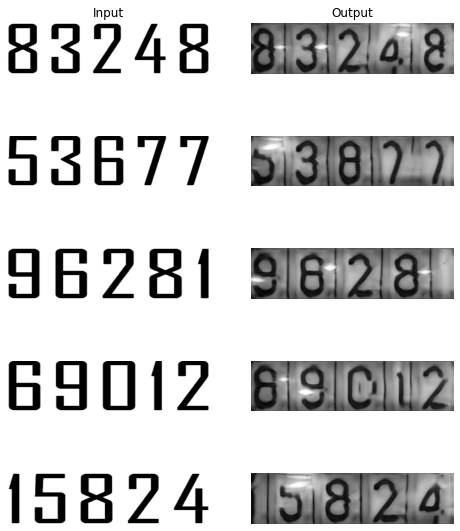

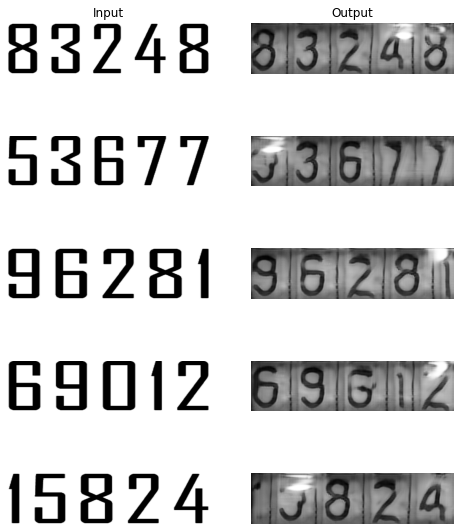

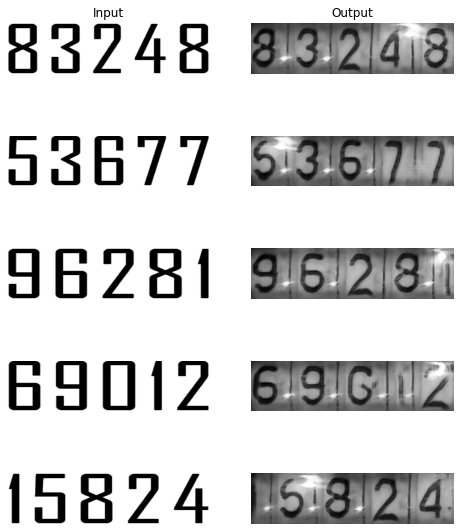

In [12]:
cgModel.train(train_A, train_B, test_A, n_testimages=N_TEST, epochs=EPOCHS, epochs_before_save=2)